<a href="https://colab.research.google.com/github/JoeyThirawat/RAI2.2-ComputerVisions/blob/main/Wk10_CV_23Mar22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Week10-Computer Visions-23 March 2022

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


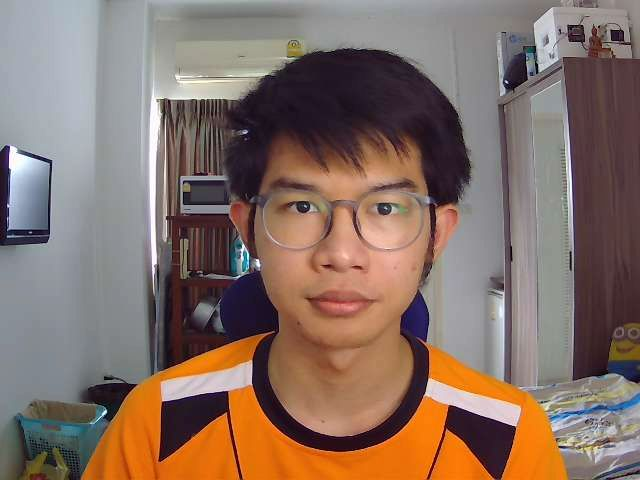

In [6]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Detected 1 faces!


-1

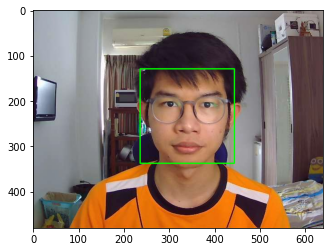

In [12]:
casePath = "/content/drive/MyDrive/dataset/haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(casePath)

image = cv2.imread(filename)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
rgbImg = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor = 1.1,
    minNeighbors = 5,
    minSize = (1,1),
    flags = cv2.CASCADE_SCALE_IMAGE
)
print("Detected {0} faces!".format(len(faces)))

for (x, y, w, h) in faces:
  cv2.rectangle(rgbImg, (x, y), (x+w, y+w), (0,255,0), 2)

plt.imshow(rgbImg)
cv2.waitKey(0)

# 63011357